In [2]:
# Importing required libraries
import numpy as np
import os
import cv2
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_CLASSES = 29

In [4]:
# Mounting the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Importing the datasets
train_path='/content/drive/MyDrive/cityscapes_data/train'
validation_path='/content/drive/MyDrive/cityscapes_data/val'
train_images=[]
train_masks=[]
val_images=[]
val_masks=[]

In [6]:
# Color pallete with 29 different colors
color_palette= np.array([
    [0, 0, 0],
    [111, 74, 0],
    [81, 0, 81],
    [128, 64, 128],
    [244, 35, 232],
    [250, 170, 160],
    [230, 150, 140],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [180, 165, 180],
    [150, 100, 100],
    [150, 120, 90],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [70, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 0, 90],
    [0, 0, 110],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
    ])

In [12]:
# Image processing of the dataset
def getLabel(img):
    """turn a 3 channel RGB image to 1 channel index image"""
    height, width, channel = img.shape
    m_label = np.zeros((height, width, 1), dtype=np.uint8)
    for w in range(width):
        for h in range(height):
            blue, green, red = img[h, w, :]
            m_label[h, w, :]=np.argmin(np.linalg.norm(np.array([red, green, blue])-color_palette,axis=1),axis=0)
    return m_label

    return one_hot_mask.numpy()

def loadImages(path, MAX):
    temp_image, temp_masks=[],[]
    images = glob(os.path.join(path,'*.jpg'))
    count = 0
    for i in tqdm(images):
        if count < MAX:
            i = cv2.imread(i)
            image = i[:, :256]
            image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
            mask = i[:, 256:]
            label = getLabel(mask)
            temp_masks.append(label)
            temp_image.append(image)
            count+=1
    return np.array(temp_image),np.array(temp_masks)

In [17]:
# Training the Model
def dataGenerator(image, mask):
    dataset = tf.data.Dataset.from_tensor_slices((image, mask))
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_images, train_masks = loadImages(train_path,MAX=500)
val_images, val_masks = loadImages(validation_path,MAX=50)


train_dataset = dataGenerator(train_images, train_masks)
validation_dataset = dataGenerator(val_images, val_masks)
print("Train Dataset:", train_dataset)
print("Val Dataset:", validation_dataset)

def convolutionBlock(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False,):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal(),)(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolutionBlock(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolutionBlock(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolutionBlock(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolutionBlock(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolutionBlock(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolutionBlock(x, kernel_size=1)
    return output

100%|██████████| 500/500 [01:10<00:00,  7.14it/s]

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.uint8, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.uint8, name=None))>


In [18]:
# DeepLab Architecture
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]), interpolation="bilinear")(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolutionBlock(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolutionBlock(x)
    x = convolutionBlock(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]), interpolation="bilinear")(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [19]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [21]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset,validation_data=validation_dataset, epochs=5)

Epoch 1/5
125/125 [==============================] - 988s 8s/step - loss: 0.9626 - accuracy: 0.7485 - val_loss: 1.8256 - val_accuracy: 0.5080
Epoch 2/5
125/125 [==============================] - 979s 8s/step - loss: 0.7383 - accuracy: 0.7976 - val_loss: 2.6298 - val_accuracy: 0.4724
Epoch 3/5
125/125 [==============================] - 976s 8s/step - loss: 0.6628 - accuracy: 0.8124 - val_loss: 2.5854 - val_accuracy: 0.4255
Epoch 4/5
125/125 [==============================] - 975s 8s/step - loss: 0.6217 - accuracy: 0.8213 - val_loss: 3.1900 - val_accuracy: 0.3325
Epoch 5/5
125/125 [==============================] - 967s 8s/step - loss: 0.5795 - accuracy: 0.8306 - val_loss: 3.2746 - val_accuracy: 0.4119


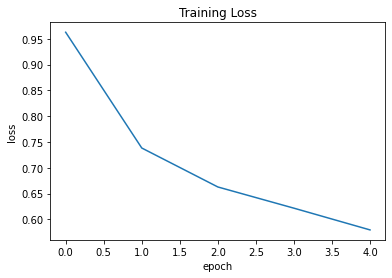

In [23]:
# Plottig the accuracy for evaluation
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

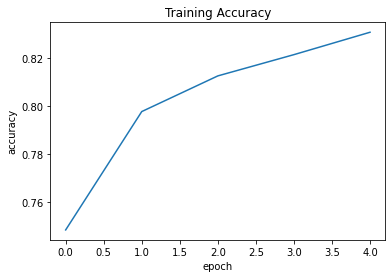

In [24]:
plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.savefig("accuracy.png")

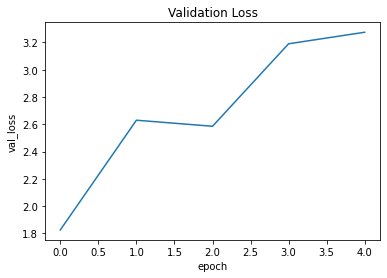

In [25]:
plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.savefig("val_loss.png")

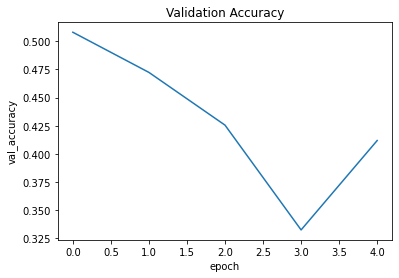

In [26]:
plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.savefig("val_accuracy.png")
model.save("my_model")